# Sää ja sähkö


In [1]:
import datetime as dt
import xmltodict
import pandas as pd
from catboost import Pool, CatBoostRegressor
from fmiopendata.wfs import download_stored_query
import seaborn as sns


def date_range(start_date, end_date, max_days):
    current_date = start_date
    while (end_date - current_date).days > max_days:
        chunk_end = current_date + dt.timedelta(days=max_days - 1)
        yield (current_date, chunk_end)
        current_date = chunk_end + dt.timedelta(days=1)
    yield (current_date, end_date)

# Weather data

Weather data is collected from [Finnish Meteorological Institute open data](https://en.ilmatieteenlaitos.fi/open-data) with [`fmiopendata`](https://github.com/pnuu/fmiopendata) Python library.


In [2]:
def get_weather_df(start_date: dt.date, end_date: dt.date) -> pd.DataFrame:
    """Fetch weather data between given dates

    Args:
        start_date (dt.date): Start date of requested weather data
        end_date (dt.date): End date of requested weather data
    """
    weather_data = {}
    for start, end in date_range(start_date, end_date, 31):
        start_string = start.strftime("%Y-%m-%d") + "T00:00:00Z"
        end_string = end.strftime("%Y-%m-%d") + "T23:59:59Z"
        data_chunk = download_stored_query(
            "fmi::observations::weather::hourly::multipointcoverage",
            [
                "place=kaisaniemi,helsinki",
                "starttime=" + start_string,
                "endtime=" + end_string,
            ],
        ).data
        weather_data.update(data_chunk)

    dates = []
    air_temperatures = []
    wind_speeds = []
    precipitation_amounts = []

    for datetime, data in weather_data.items():
        dates.append(datetime)
        air_temperatures.append(data["Helsinki Kaisaniemi"]["Air temperature"]["value"])
        wind_speeds.append(data["Helsinki Kaisaniemi"]["Wind speed"]["value"])
        precipitation_amounts.append(
            data["Helsinki Kaisaniemi"]["Precipitation amount"]["value"]
        )

    weather_df = pd.DataFrame(
        {
            "datetime": dates,
            "air temperatures": air_temperatures,
            "wind speeds": wind_speeds,
            "precipitation amounts": precipitation_amounts,
        }
    )

    return (weather_data, weather_df)

# Energy data

Energy data is obtained from [ENTSO-E (European Network of Transmission System Operators for Electricity) API](https://transparency.entsoe.eu/load-domain/r2/totalLoadR2/show).


Not enough energy data for 2024-03-04 01:00:00
             datetime  consumption
0 2024-01-01 01:00:00     12429.75
1 2024-01-01 02:00:00     12297.75
2 2024-01-01 03:00:00     12168.50
3 2024-01-01 04:00:00     12185.00
4 2024-01-01 05:00:00     12229.75


<Axes: >

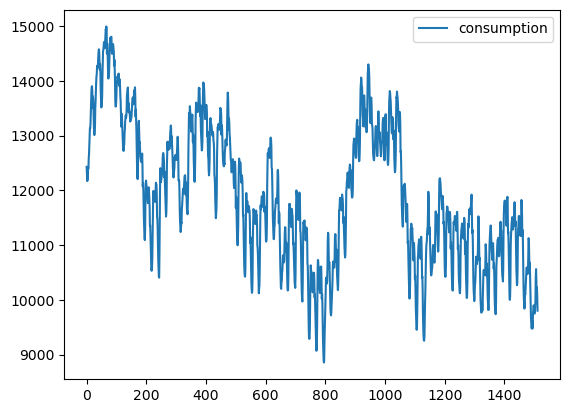

In [3]:
energy_data_file_names = ["data/ACTUAL_TOTAL_LOAD_202401010000-202501010000.xml"]
data = []
for filename in energy_data_file_names:
    with open(filename, "r") as file:
        data_string = file.read()
        yearly_data = xmltodict.parse(data_string)["GL_MarketDocument"]["TimeSeries"]
        data += yearly_data

energy_data = [day["Period"] for day in data]
hourly_means = {}

times = []
values = []

for day in energy_data:
    time = dt.datetime.strptime(
        day["timeInterval"]["start"], "%Y-%m-%dT%H:%MZ"
    ) + dt.timedelta(hours=2)
    fifteen_min_means = [int(fifteen_min["quantity"]) for fifteen_min in day["Point"]]
    if len(fifteen_min_means) != 96:
        print("Not enough energy data for", time)
        break
    i = 0
    while i < len(fifteen_min_means):
        hourly_means[time] = sum(fifteen_min_means[i : i + 4]) / 4
        times.append(time)
        values.append(sum(fifteen_min_means[i : i + 4]) / 4)
        time += dt.timedelta(hours=1)
        i += 4

energy_df = pd.DataFrame({"datetime": times, "consumption": values})
print(energy_df.head())
sns.lineplot(energy_df)

# Predictions

Predictions are made with [CatBoost library](https://catboost.ai/).


In [4]:
start_date = dt.date(2024, 1, 1)
end_date = dt.date(2024, 3, 3)
weather_data = get_weather_df(start_date, end_date)[0]

data_matrix = []
labels = []
day_of_week = 0
for time, weather in weather_data.items():
    if time not in hourly_means:
        print("No energy data for", time)
        continue
    data_matrix.append(
        [
            weather["Helsinki Kaisaniemi"]["Air temperature"]["value"],
            weather["Helsinki Kaisaniemi"]["Wind speed"]["value"],
            weather["Helsinki Kaisaniemi"]["Precipitation amount"]["value"],
            str(day_of_week),
        ]
    )
    if time.hour == 23:
        day_of_week = (day_of_week + 1) % 7
    labels.append(hourly_means[time])

# print("data_matrix")
# print(data_matrix[:10])

train_data = data_matrix[: int(0.8 * len(data_matrix))]
test_data = data_matrix[int(0.8 * len(data_matrix)) :]

train_pool = Pool(train_data, labels[: int(0.8 * len(labels))], cat_features=[3])
test_pool = Pool(test_data, cat_features=[3])
model = CatBoostRegressor(iterations=2, depth=2, learning_rate=1, loss_function="RMSE")
model.fit(train_pool)
predictions = model.predict(test_pool)
# print(f"{train_data = }")
# print(f"{test_data = }")

print(predictions)

No observations found
No energy data for 2024-01-01 00:00:00
0:	learn: 702.7203757	total: 48.9ms	remaining: 48.9ms
1:	learn: 628.4666703	total: 49.4ms	remaining: 0us
[11927.23497497 11927.23497497 11927.23497497 11927.23497497
 11927.23497497 11927.23497497 11927.23497497 11927.23497497
 11927.23497497 11927.23497497 11927.23497497 13323.11174537
 13323.11174537 13323.11174537 13323.11174537 11927.23497497
 11927.23497497 11927.23497497 11927.23497497 11927.23497497
 11927.23497497 11927.23497497 11927.23497497 11927.23497497
 11927.23497497 11927.23497497 11927.23497497 11927.23497497
 11927.23497497 11927.23497497 11927.23497497 11927.23497497
 11927.23497497 11927.23497497 11927.23497497 11927.23497497
 11927.23497497 11927.23497497 11927.23497497 11927.23497497
 11927.23497497 11927.23497497 11927.23497497 11927.23497497
 11927.23497497 11253.47242379 11253.47242379 11253.47242379
 11253.47242379 11253.47242379 11253.47242379 11623.24623976
 11623.24623976 11253.47242379 11253.4724

/home/tuukkala/anaconda3/envs/sus/lib/python3.11/site-packages/fmiopendata/utils.py:43: UserWarning: 

FMI servers responded with the following errors:

 - Too long time interval requested!
 - No more than 744.000000 hours allowed.
 - URI: /wfs?endtime=2024-03-03T23%3A59%3A59Z&place=kaisaniemi%2Chelsinki&request=getFeature&service=WFS&starttime=2024-02-01T00%3A00%3A00Z&storedquery_id=fmi%3A%3Aobservations%3A%3Aweather%3A%3Ahourly%3A%3Amultipointcoverage&version=2.0.0

  warnings.warn(exception_text)


In [5]:
# forecast accuracy with MAPE

# mape results
# (iterations=2, depth=2, learning_rate=1, loss_function="RMSE") -> 0.04859686603768826

mapes = {}

actual = labels[int(0.8 * len(labels)) :]

for i in range(1, 20):
    for k in range(10):
        for l in ["RMSE", "MAE"]:
            model = CatBoostRegressor(iterations=i, depth=k, loss_function=l)
            model.fit(train_pool)
            predictions = model.predict(test_pool)

            mape = 0
            for p in range(len(predictions)):
                mape += abs((actual[p] - predictions[p]) / actual[p]) / len(predictions)

            # print(f"{mape = }")
            mapes[(i, k, l)] = mape
            print(".")

print(mapes)

Learning rate set to 0.5
0:	learn: 1042.1593411	total: 391us	remaining: 0us
.
0:	learn: 851.7992414	total: 440us	remaining: 0us
.
Learning rate set to 0.5
0:	learn: 833.9597074	total: 333us	remaining: 0us
.
0:	learn: 837.6809926	total: 364us	remaining: 0us
.
Learning rate set to 0.5
0:	learn: 805.2976839	total: 451us	remaining: 0us
.
0:	learn: 837.5017502	total: 422us	remaining: 0us
.
Learning rate set to 0.5
0:	learn: 753.9550956	total: 463us	remaining: 0us
.
0:	learn: 836.2184169	total: 580us	remaining: 0us
.
Learning rate set to 0.5
0:	learn: 749.3950005	total: 617us	remaining: 0us
.
0:	learn: 834.5166871	total: 599us	remaining: 0us
.
Learning rate set to 0.5
0:	learn: 723.5905174	total: 609us	remaining: 0us
.
0:	learn: 834.3514598	total: 697us	remaining: 0us
.
Learning rate set to 0.5
0:	learn: 723.5691808	total: 686us	remaining: 0us
.
0:	learn: 834.3437704	total: 797us	remaining: 0us
.
Learning rate set to 0.5
0:	learn: 723.5642579	total: 896us	remaining: 0us
.
0:	learn: 834.07161

In [7]:
# joining the weather and consumption data

train_weather = get_weather_df(dt.date(2023, 1, 1), dt.date(2023, 12, 31))[1]

train_data = train_weather.set_index("datetime").join(energy_df.set_index("datetime"))